#### Предсказание отказов жёстких дисков  с использованием S.M.A.R.T данных собраных в течении года в одном из датацентров [BACKBLAZE](https://www.backblaze.com/b2/hard-drive-test-data.html)

Формально, наша задача - Panel Data Forecasting. Panel Data - это обобщение временных рядов (Time Series), когда независимых
переменных несколько. Либо же наоборот - временные ряда, являються частным случаем Panel Data.
Большая часть методов обращения с Panel Data предполагают заранее известным вид взаимосвязи между текущими значениями переменных
и предшествующими а так же вид взаимосвязи между самими переменными (например - нет взаимосвязи, линейная взаимосвязь и т.д.).
Здесь используется другой подход: мы не предполагаем заранее известным вид взаимосвязи, как раз ёе мы и должны найти или точнее
аппроксимировать используя Machine Learning.

Импортируем необходимые библиотеки

In [45]:
from collections import Counter
import glob
import random
import os
import time
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, KFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, auc, roc_auc_score, f1_score, classification_report, confusion_matrix

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

Производим необходимые настройки, присваемаем значения глобальным переменным, создаём список файлов с данными.

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [4]:
DATA_DIR = '../data/unarch/data_Q*_2019/'

In [5]:
num_notfeature_columns = 4

In [6]:
min_list_of_columns = [
    'date',
    'serial_number',
    'model',
    'capacity_bytes',
    'failure',
    'smart_3_normalized',
    'smart_187_normalized',
    'smart_193_normalized',
    'smart_195_normalized',
    'smart_240_normalized',
    'smart_241_normalized'
]

In [119]:
datafiles = sorted(glob.glob(DATA_DIR + '*.csv'))

In [ ]:
Определяем функции необходимые для дальнейшей работы.

In [8]:
def compute_num_of_nans(datafiles):
    df = pd.read_csv(datafiles[0])
    total_len = len(df)
    num_of_nans = {col_name:len(df.loc[df[col_name].isna()]) for col_name in df.columns.to_list()}
    common_col_names_set = set(num_of_nans)
    all_col_names_list = df.columns.to_list()
    for datafile in datafiles[1:]:
        df = pd.read_csv(datafile)
        total_len += len(df)
        col_names = df.columns.to_list() #[num_n:]
        common_col_names_set = common_col_names_set.intersection(set(col_names))
        for col_name in col_names:
            if col_name in num_of_nans:
                num_of_nans[col_name] += len(df.loc[df[col_name].isna()])
            else:
                num_of_nans[col_name] = len(df.loc[df[col_name].isna()])
            if col_name not in all_col_names_list:
                col_names_idx = col_names.index(col_name)
                precend_col_name = col_names[col_names_idx - 1]
                all_col_names_idx = all_col_names_list.index(precend_col_name)
                all_col_names_list.insert(all_col_names_idx, col_name)
    common_col_names_list = [col_name for col_name in all_col_names_list if col_name in common_col_names_set]            
    num_of_nans = {col_name:num_of_nans[col_name] for col_name in common_col_names_set}
    gc.collect()
    return total_len, num_of_nans, common_col_names_list

In [9]:
def drop_dominate_nans_columns(df, drop_column_nan_threshold_ratio=None):
    if drop_column_nan_threshold_ratio:
        drop_column_nan_threshold = df.shape[0] // drop_column_nan_threshold_ratio
    else:
        drop_column_nan_threshold = df.shape[0] // 2
    return df[
        [col for col in df.columns if len(df.loc[df[col].isna()]) < drop_column_nan_threshold]
    ]

In [10]:
def fill_column_nans(df, column_name):
    #calculate number of NaNs in column
    na_len = len(df.loc[df[column_name].isna(), column_name])
    #create a pandas series containing values and corresponding quantities from not NaNs part of the column
    count_notna = df.loc[df[column_name].notna(), column_name].value_counts()
    #calculate relative frequencies (probabilities) of each value
    frequencies = count_notna / count_notna.sum()
    #make array that contain fill values with the same relative frequencies as in 'not NaN' column part
    fill_values = np.array(
        [np.random.choice(frequencies.index, p=frequencies.values) for _ in range(na_len)]
    )
    #fill NaNs
    df.loc[df[column_name].isna(), column_name] = fill_values
    return df

In [11]:
def fill_nans(df, column_names):
    for column_name in column_names:
        fill_column_nans(df, column_name)
    return df

In [12]:
def fill_nans(df):
    columns_with_nans = df.columns.to_list()[num_notfeature_columns:]
    fill_values = {col_name: np.round(df[col_name].astype(np.float64).mean()) for col_name in columns_with_nans}
    return df.fillna(value=fill_values)

In [13]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    #print(('Memory usage of dataframe is {:.2f}MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    #print(('Memory usage after optimization is: {:.2f} MB').format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [14]:
def create_data_df(datafiles, total_len, num_of_nans, common_col_names_list, drop_column_nan_threshold_ratio=None):
    
    if drop_column_nan_threshold_ratio:
        drop_column_nan_threshold = total_len // drop_column_nan_threshold_ratio
    else:
        drop_column_nan_threshold = total_len // 2
    
    not_dominate_nan_columns = [
        col_name for col_name, col_num_of_nans in num_of_nans.items() if col_num_of_nans < drop_column_nan_threshold
    ]
    
    not_dominate_nan_columns = [col_name for col_name in common_col_names_list if col_name in not_dominate_nan_columns]
    
    data_df = reduce_mem_usage(pd.read_csv(datafiles[0], usecols=not_dominate_nan_columns))
    
    for datafile in datafiles[1:]:
        df = pd.read_csv(datafile, usecols=not_dominate_nan_columns)
        data_df = pd.concat([data_df, reduce_mem_usage(df)])
    not_dominate_nan_columns[3] = 'failure'
    not_dominate_nan_columns[4] = 'capacity_bytes'
    
    data_df = data_df[not_dominate_nan_columns]
    gc.collect()
    return data_df.reset_index().drop(['index'], axis=1)

In [15]:
def scale_and_one_hot_encoding(df, scaler):
    features_columns = df.columns.to_list()[num_notfeature_columns:]
    
    scaled_features = pd.DataFrame(
        scaler.fit_transform(df[features_columns]), columns=features_columns, index=df.index, dtype=np.float16
    )
    
    return pd.concat(
        [df[df.columns.to_list()[:num_notfeature_columns]], scaled_features], axis=1
    ).reset_index().drop(['index', 'model', 'date', 'serial_number'], axis=1)

In [16]:
def get_precedings_num(begin, end):
    return random.randint(begin, end)

In [17]:
def select_failure_events_with_preceding(df, preceding_min_subset_len=10, preceding_max_subset_len=40, preceding_len_random=True):
    preceding_subset_len = preceding_min_subset_len
    if preceding_len_random:
        preceding_subset_len = random.randint(preceding_min_subset_len, preceding_max_subset_len)
    selected_df = pd.DataFrame()
    failure_events = df[df['failure'] == 1]
    failure_indexes = failure_events.index.to_list()
    for idx in failure_indexes:
        preceding = df.loc[(idx - preceding_subset_len):(idx - 1)]
        preceding_indexes = preceding.index.to_list()
        intersect = set(failure_indexes).intersection(set(preceding_indexes))
        if intersect:
            selected_df = pd.concat([selected_df, df.loc[(max(intersect) + 1):idx]])
        else:
            selected_df = pd.concat([selected_df, df.loc[(idx - preceding_subset_len):idx]])
    return selected_df.reset_index().drop(['index'], axis=1)

In [415]:
def divide_features_and_target(df):
    #return df[df.columns.to_list()[num_notfeature_columns:]], df['failure']
    return df[df.columns.to_list()[1:]], df['failure']

In [19]:
def match_exactly(y_test, y_pred):
    false_negatives = 0
    false_positives = 0
    true_positives = 0
    true_negatives = 0
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == 1 and y_p == 0:
            false_negatives += 1
        elif y_t == 0 and y_p == 1:
            false_positives += 1
        elif y_t == 1 and y_p == 1:
            true_positives += 1
        elif y_t == 0 and y_p == 0:
            true_negatives += 1
    print(
        "false_negatives: {}, false_positives: {}, true_negatives: {}, true_positives: {}".format(
            false_negatives, false_positives, true_negatives, true_positives)
    )

Вычисляем количество NaNs в каждом столбце за весь год. Так же (на всякий случай) находим имена столбцов которые встречаються
во всех файлах с данными. И вычисляем количество строк в общем датафрейме которые будет создан при обьединении данных содержашихся
во всех файлах с данными.

In [120]:
start_time = time.time()
data_df_total_len, num_of_nans, common_col_names_list = compute_num_of_nans(datafiles)
print("time_elapsed: {} min ".format((time.time() - start_time) / 60))

time_elapsed: 34.6376409649849 min 


Создаём объединённый датафрейм отбрасывая столбцы в которых NaN-ов больше некоторого порога - по умолчанию больше половины 
количества строк в объединённом датафрейме. Так же производим оптимизацию памяти занимаемой объединённым датафреймом.

In [121]:
start_time = time.time()
data_df = create_data_df(datafiles, data_df_total_len, num_of_nans, common_col_names_list)
print("time_elapsed: {} min ".format((time.time() - start_time) / 60))

time_elapsed: 80.05467269420623 min 


Сохраняем объединённый датафрейм, что бы в дальнейшем не создавать его каждый раз заново.

In [122]:
data_df.to_hdf('data_df.hdf5', key='df', mode='w')

Заполняем NaN-ы в неотброшенных столбцах - т.е. таких в которых NaN-ов меньше половины длинны столбца. Лучший подход здесь - 
заполение NaN-ов значениями из not NaNs части столбца пропорционально частоте (вероятности) каждого значения. Но это очень медленно , к тому же большая часть столбцов содержит весьма значительное количество уникальных значений, что обессмысливает данный подход.
Поэтому NaN-ы заполняються средним арифметическим not NaN значений в столбце.

In [125]:
start_time = time.time()
ordered_not_nans_data_df = fill_nans(data_df)
print("time_elapsed: {} min ".format((time.time() - start_time) / 60))

time_elapsed: 0.6688740770022075 min 


In [126]:
gc.collect()

1451

In [ ]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

Масштабирование данных должно улучшать предсказательную силу ML модели. Так же есть предположение, что частота отказов дисков может  существенно зависить от модели диска. Для того что бы ML модель учла модель диска необходимо использовать one hot encoding. Но строк в объединённом датафрейме 40737546 уникальных значений модели диска 55, при использовании one hot encoding в объединённый датафрейм добавится 55 столбца каждый длинной 40737546, что катастрофически увеличит объём памяти занимаемой датафреймом, было принято решение просто не учитывать модель диска при построении ML модели. В дальнейшем имело бы смысл произвести исследование влияния модел диска на аварийность "вручную" используя аппарат математической статистики.
Масштабирование в этой версии решения задачи так же не производится, для того что бы посмотреть на предсказательную силу ML модели в наихудшем случае.

In [ ]:
start_time = time.time()
data_df = scale_and_one_hot_encoding(data_df, min_max_scaler)
print("time_elapsed: {} min ".format((time.time() - start_time) / 60))

In [ ]:
gc.collect()

In [ ]:
data_df.to_hdf('optimized_data_df.hdf5', key='df', mode='w')

In [20]:
data_df = pd.read_hdf('optimized_data_df.hdf5')

In [285]:
len(data_df[data_df['failure'] == 1])

2263

В некотором смысле решающий момент - выборка из объединённого датафрейма данных которые будут переданы ML модели для обучения. Весь датафрейм передавать нет смысла - наличествует очень большой перекос (bias) в данных: 2263 строк в которых значение столбца failure равно 1 (из 40737546 строк). Сколько нибудь сложных методов отбора не используеться, для доказательства работоспособности методики это излишне. Выбираем саму "аварийную" строку и несколько предшествующих (в данном случае 3).

In [416]:
start_time = time.time()
selected_data_df = select_failure_events_with_preceding(
    ordered_not_nans_data_df,
    preceding_min_subset_len=2,
    preceding_len_random=False
)
print("time_elapsed: {} min ".format((time.time() - start_time) / 60))

KeyboardInterrupt: 

In [417]:
selected_data_df.head()

,failure,capacity_bytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,0,8001563222016,79.0,84603744.0,88.0,0.0,100.0,6.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,1.349800e+04,100.0,4.461635e+10,100.0,1.016638e+11
1,0,4000787030016,108.0,20963336.0,94.0,0.0,100.0,6.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,2.590400e+04,100.0,4.458936e+10,100.0,1.182198e+11
2,1,8001563222016,57.0,184212592.0,92.0,0.0,100.0,6.0,93.0,29616.0,...,100.0,0.0,200.0,0.0,100.0,1.239600e+04,100.0,3.950897e+10,100.0,8.143129e+10
3,0,4000787030016,100.0,0.0,100.0,427.0,100.0,8.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,2.462897e+11,100.0,4.957939e+10,100.0,1.182294e+11
4,0,4000787030016,111.0,31901456.0,92.0,0.0,100.0,8.0,100.0,0.0,...,100.0,0.0,200.0,0.0,100.0,3.050900e+04,100.0,5.465408e+10,100.0,1.114084e+11


Разбиваем данные на независмые переменные (features) X и зависимую (target) y.

In [418]:
start_time = time.time()
X, y = divide_features_and_target(selected_data_df)
print("time_elapsed: {} min ".format((time.time() - start_time) / 60))

time_elapsed: 8.927583694458008e-05 min 


In [419]:
X.head()

,capacity_bytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,8001563222016,79.0,84603744.0,88.0,0.0,100.0,6.0,100.0,0.0,94.0,...,100.0,0.0,200.0,0.0,100.0,1.349800e+04,100.0,4.461635e+10,100.0,1.016638e+11
1,4000787030016,108.0,20963336.0,94.0,0.0,100.0,6.0,100.0,0.0,84.0,...,100.0,0.0,200.0,0.0,100.0,2.590400e+04,100.0,4.458936e+10,100.0,1.182198e+11
2,8001563222016,57.0,184212592.0,92.0,0.0,100.0,6.0,93.0,29616.0,96.0,...,100.0,0.0,200.0,0.0,100.0,1.239600e+04,100.0,3.950897e+10,100.0,8.143129e+10
3,4000787030016,100.0,0.0,100.0,427.0,100.0,8.0,100.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,2.462897e+11,100.0,4.957939e+10,100.0,1.182294e+11
4,4000787030016,111.0,31901456.0,92.0,0.0,100.0,8.0,100.0,0.0,87.0,...,100.0,0.0,200.0,0.0,100.0,3.050900e+04,100.0,5.465408e+10,100.0,1.114084e+11


Разделяем данные на обучающие и тестовые.

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

Для начала используем логистическую регрессию в качестве ML модели, далее её используем как базовую для сравнения с более сложными моделями.

In [136]:
log_reg_model = LogisticRegression()

In [137]:
log_reg_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Вычисляем prediction на тестовых данных.

In [286]:
y_pred = log_reg_model.predict(X_test)

Вычисляем accuracy.

In [139]:
accuracy_score(y_test, y_pred)

0.6823806717737183

Как видим accuracy невелика, но лучше чем 0.5.

Вычисляем confusion matrix.

In [140]:
confusion_matrix(y_test, y_pred)

array([[1125,    6],
       [ 533,   33]])

Видим что верно предсказанных сбоев - 33, неверно предсказанных - 6, непредсказанных - 533, верно предсказанных "несбоев": 1125 из 1697 событий в тестовой выборке. Результат не очень хороший. Но во общем для логистической регресси это и предполагалось.

##### Далее строим Gradient Boosting модели. Будут использоваться простейшие настройки без тонкого тюнинга моделей.

Используем XGBoost - очень хорошо зарекомендававшую библиотеку для построения Gradient Boosting моделей.

Создаём pipeline, на случай если в дальнейшем нам надо будет ещё добвавить действия (например дополнительную обработку данных) до или после вызова XGBoost классификатора.

In [147]:
xgb_pipeline = Pipeline([('xgb', XGBClassifier())])

Задаём наборы параметров для XGB классификатора. Они будут использованы для поиска по сетке наилучешего набора параметров, с использованием GridSearchCV.

In [148]:
xgb_param_grid = {
    'xgb__n_estimators': [10, 50, 100, 500],
    'xgb__learning_rate': [0.1, 0.5, 1]
}

xgb_fit_params = {
    'xgb__eval_set': [(X_test, y_test)],
    'xgb__early_stopping_rounds': 10,
    'xgb__verbose': 3
}

In [149]:
xgb_search_cv = GridSearchCV(xgb_pipeline, cv=5, param_grid=xgb_param_grid)

In [150]:
start_time = time.time()
xgb_search_cv.fit(X_train, y_train, **xgb_fit_params)
print("elapsed time: {} min".format((time.time() - start_time) / 60))

[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.129641
[6]	validation_0-error:0.131408
[9]	validation_0-error:0.124926
[0]	validation_0-error:0.13023
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.132587
[6]	validation_0-error:0.131408
[9]	validation_0-error:0.128462
[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.127873
[6]	validation_0-error:0.125516
[9]	validation_0-error:0.123159
[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.131408
[6]	validation_0-error:0.127283
[9]	validation_0-error:0.123748
[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.129641
[6]	validation_0-error:0.131408
[9]	validation_0-error:0.124337
[0]	validation_0-error:0.129641

[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.13023
[6]	validation_0-error:0.124337
[9]	validation_0-error:0.124337
[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.128462
[6]	validation_0-error:0.128462
[9]	validation_0-error:0.123748
[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.126105
[6]	validation_0-error:0.123748
[9]	validation_0-error:0.122569
[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.128462
[6]	validation_0-error:0.124337
[9]	validation_0-error:0.122569
[12]	validation_0-error:0.126105
[15]	validation_0-error:0.124337
[18]	validation_0-error:0.123159
[21]	validation_0-error:0.120801
[24]	validation_0-error:0.122569
[27]	validation_0-error:0.119623
[30]	validation_0-error:0.1

Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.130819
[6]	validation_0-error:0.131408
[9]	validation_0-error:0.129051
[12]	validation_0-error:0.133176
[15]	validation_0-error:0.131408
Stopping. Best iteration:
[5]	validation_0-error:0.126694

[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.136123
[6]	validation_0-error:0.13789
[9]	validation_0-error:0.135533
Stopping. Best iteration:
[0]	validation_0-error:0.129641

[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validation_0-error:0.128462
[6]	validation_0-error:0.123748
[9]	validation_0-error:0.126694
[12]	validation_0-error:0.128462
[15]	validation_0-error:0.132587
[18]	validation_0-error:0.135533
Stopping. Best iteration:
[8]	validation_0-error:0.12198

[0]	validation_0-error:0.129641
Will train until validation_0-error hasn't improved in 10 rounds.
[3]	validati

Так же как и для логистической регресси находим prediction на тестовых данных.

In [153]:
y_pred_xgb = xgb_search_cv.best_estimator_.predict(X_test)

Вычисляем accuracy:

In [154]:
accuracy_score(y_test, y_pred_xgb)

0.8791985857395404

Как видим accuracy уже значительно лучше.

Вычисляем confusion matrix.

In [155]:
confusion_matrix(y_test, y_pred_xgb)

array([[1079,   52],
       [ 153,  413]])

Как видим XGBoost верно предсказал 413 отказов, неверно предсказал 52 отказа, не предсказал 153, верно предсказал 1079 "неотказов" что уже можно использовать в "боевой" обстановке.

Далее используем LightGBM - библиотеку соперничающюю с XGBoost в эффективности. Производим те же самые шаги что и для XGBoost.

In [55]:
lgbm_pipeline = Pipeline([('lgbm', LGBMClassifier())])

In [158]:
lgbm_param_grid = {
    'lgbm__n_estimators': [10, 50, 100, 500],
    'lgbm__learning_rate': [0.1, 0.5, 1]
}

lgbm_fit_params = {
    'lgbm__early_stopping_rounds': 30, 
    'lgbm__eval_metric': 'auc', 
    'lgbm__eval_set': [(X_test,y_test)],
    'lgbm__eval_names': 'valid',
    'lgbm__verbose': 100,
}

In [159]:
lgbm_search_cv = GridSearchCV(lgbm_pipeline, cv=5, param_grid=lgbm_param_grid)

In [160]:
start_time = time.time()
lgbm_search_cv.fit(X_train, y_train, **lgbm_fit_params)
print("elapsed time: {} min".format((time.time() - start_time) / 60))

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[10]	valid's auc: 0.892011	valid's binary_logloss: 0.398001
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[9]	valid's auc: 0.890071	valid's binary_logloss: 0.401398
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[10]	valid's auc: 0.893327	valid's binary_logloss: 0.390988
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[8]	valid's auc: 0.892503	valid's binary_logloss: 0.410426
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[6]	valid's auc: 0.892297	valid's binary_logloss: 0.444032
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[22]	valid's auc: 0.895938	valid's binary_logloss

Early stopping, best iteration is:
[1]	valid's auc: 0.879387	valid's binary_logloss: 0.363692
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.877633	valid's binary_logloss: 0.371273
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid's auc: 0.888061	valid's binary_logloss: 0.354206
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.884003	valid's binary_logloss: 0.365203
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid's auc: 0.890572	valid's binary_logloss: 0.360682
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.879387	valid's binary_logloss: 0.363692
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid's auc: 0.877633	valid's b

In [161]:
y_pred_lgbm = lgbm_search_cv.best_estimator_.predict(X_test)

In [162]:
accuracy_score(y_test, y_pred_lgbm)

0.8768414849734826

Что ж accuracy относительно неплох и примерно равен accuracy для XGBoost.

Кроме accuracy вычисляем roc auc.

In [163]:
roc_auc_score(y_test, y_pred_lgbm)

0.8414080537877296

roc auc относительно неплох.

In [164]:
confusion_matrix(y_test, y_pred_lgbm)

array([[1072,   59],
       [ 150,  416]])

confusion matrix выглядит чуть получше чем у XGBoost.

Объединяем прдсказания XGBoost и LightGBM (ставим 1 там где хотя бы одна из моделей ставит 1)

In [165]:
y_pred_xgb_lgbm = pd.Series(y_pred_xgb).combine(pd.Series(y_pred_lgbm), lambda u, v: u or v, fill_value=1)

In [166]:
accuracy_score(y_test, y_pred_xgb_lgbm)

0.8803771361225693

In [167]:
roc_auc_score(y_test, y_pred_xgb_lgbm)

0.8489149350304462

In [168]:
confusion_matrix(y_test, y_pred_xgb_lgbm)

array([[1067,   64],
       [ 139,  427]])

Как видим посредством объединения удалось добиться некоторого улучшения.

Так же небезинтересно было бы посмотреть на кривые обучения. Определяем вспомогательные функции для "рисования" соответствующих графиков.

In [169]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1, measure='accuracy'):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    
    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        color='blue',
        alpha=alpha
    )
    
    plt.plot(
        train_sizes,
        test_mean,
        label='test score',
        color='red',
        marker='o'
    )

    plt.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        color='red',
        alpha=alpha
    )
    
    plt.title(title)
    plt.xlabel("Number of training points")
    plt.ylabel("Measure {}".format(measure))
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()


def plot_validation_curve(param_range, train_scores, test_scores, title, alpha=0.1):
    param_range = [x[1] for x in param_range] 
    sort_idx = np.argsort(param_range)
    param_range=np.array(param_range)[sort_idx]
    train_mean = np.mean(train_scores, axis=1)[sort_idx]
    train_std = np.std(train_scores, axis=1)[sort_idx]
    test_mean = np.mean(test_scores, axis=1)[sort_idx]
    test_std = np.std(test_scores, axis=1)[sort_idx]
    plt.plot(param_range, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(
        param_range,
        train_mean + train_std,
        train_mean - train_std,
        color='blue',
        alpha=alpha
    )
    plt.plot(param_range, test_mean, label='test score', color='red', marker='o')
    plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, color='red', alpha=alpha)
    plt.title(title)
    plt.grid(ls='--')
    plt.xlabel('Weight of class 2')
    plt.ylabel('Average values and standard deviation for F1-Score')
    plt.legend(loc='best')
    plt.show()

In [170]:
plt.figure(figsize=(9, 6))

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [171]:
cv = KFold(n_splits=5, random_state=42)

In [172]:
xgb_train_sizes, xgb_train_scores, xgb_test_scores = learning_curve(
    estimator=xgb_search_cv.best_estimator_,
    X=X_train,
    y=y_train,
    train_sizes=np.arange(0.1, 1.1, 0.1),
    cv=cv,
    scoring='accuracy',
    n_jobs= 4
)

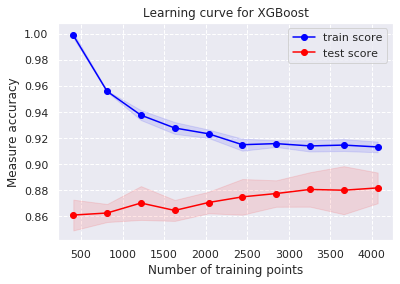

In [173]:
plot_learning_curve(
    xgb_train_sizes,
    xgb_train_scores,
    xgb_test_scores,
    title='Learning curve for XGBoost'
)

In [174]:
lgbm_train_sizes, lgbm_train_scores, lgbm_test_scores = learning_curve(
    estimator=lgbm_search_cv.best_estimator_,
    X=X_train,
    y=y_train,
    train_sizes=np.arange(0.1, 1.1, 0.1),
    cv=cv,
    scoring='roc_auc',
    n_jobs= 4
)

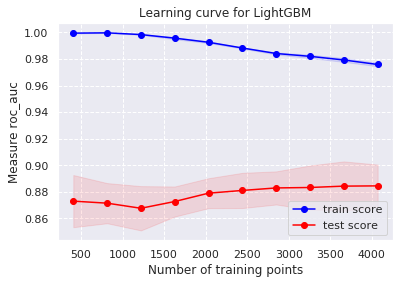

In [246]:
plot_learning_curve(
    lgbm_train_sizes,
    lgbm_train_scores,
    lgbm_test_scores,
    title="Learning curve for LightGBM",
    measure="roc_auc"
)

Как видим, кривые обучения пока далеки от совершенства.

Этот Jupyter notebook всего лишь prof of concepts.
В дальнейшем, используя более изощрённые методы борьбы с перекошенностью данных (сложные алгоритмы выбора, либо построения дополнитель точек отказа), используя более сложные модели (Neural Networks различных видов) и более тонко настраивая их скорее всего можно будет добиться очень сильного уменьшения ложных предсказаний/"непредсказаний" и увеличения правильных предсказаний.
Так же имеет смысл рассмотреть эту задачу как anomaly detection задачу.

In [288]:
data_df.columns.to_list()

['date',
 'serial_number',
 'model',
 'failure',
 'capacity_bytes',
 'smart_1_normalized',
 'smart_1_raw',
 'smart_3_normalized',
 'smart_3_raw',
 'smart_4_normalized',
 'smart_4_raw',
 'smart_5_normalized',
 'smart_5_raw',
 'smart_7_normalized',
 'smart_7_raw',
 'smart_9_normalized',
 'smart_9_raw',
 'smart_10_normalized',
 'smart_10_raw',
 'smart_12_normalized',
 'smart_12_raw',
 'smart_187_normalized',
 'smart_187_raw',
 'smart_188_normalized',
 'smart_188_raw',
 'smart_190_normalized',
 'smart_190_raw',
 'smart_192_normalized',
 'smart_192_raw',
 'smart_193_normalized',
 'smart_193_raw',
 'smart_194_normalized',
 'smart_194_raw',
 'smart_195_normalized',
 'smart_195_raw',
 'smart_197_normalized',
 'smart_197_raw',
 'smart_198_normalized',
 'smart_198_raw',
 'smart_199_normalized',
 'smart_199_raw',
 'smart_240_normalized',
 'smart_240_raw',
 'smart_241_normalized',
 'smart_241_raw',
 'smart_242_normalized',
 'smart_242_raw']

In [290]:
data_df.head(10).to_json('smart_short_0.json')

In [446]:
data_df.head(10)

,date,serial_number,model,failure,capacity_bytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
0,2019-01-01,Z305B2QN,ST4000DM000,0,4000787030016,111.0,35673128.0,91.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,26461.0,100.0,4.553972e+10,100.0,1.183566e+11
1,2019-01-01,ZJV0XJQ4,ST12000NM0007,0,12000138625024,83.0,187116872.0,98.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,3020.0,100.0,2.887057e+10,100.0,2.160959e+10
2,2019-01-01,ZJV0XJQ3,ST12000NM0007,0,12000138625024,73.0,19599104.0,99.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,670.0,100.0,6.111459e+09,100.0,7.441231e+08
3,2019-01-01,ZJV0XJQ0,ST12000NM0007,0,12000138625024,81.0,136943696.0,93.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,4166.0,100.0,3.350759e+10,100.0,3.938334e+10
4,2019-01-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,0,4000787030016,100.0,0.0,100.0,436.0,100.0,...,100.0,0.0,200.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-01,ZA16NQJR,ST8000NM0055,0,8001563222016,83.0,203857808.0,92.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,14652.0,100.0,4.771906e+10,100.0,9.485711e+10
6,2019-01-01,ZJV02XWG,ST12000NM0007,0,12000138625024,81.0,116523736.0,92.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,5512.0,100.0,3.504775e+10,100.0,4.612356e+10
7,2019-01-01,ZJV1CSVX,ST12000NM0007,0,12000138625024,82.0,171431192.0,98.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,3949.0,100.0,3.536406e+10,100.0,4.122348e+10
8,2019-01-01,ZJV02XWA,ST12000NM0007,0,12000138625024,84.0,241650824.0,97.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,5631.0,100.0,4.126671e+10,100.0,5.614299e+10
9,2019-01-01,ZA18CEBS,ST8000NM0055,0,8001563222016,82.0,177605672.0,97.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,11625.0,100.0,4.124180e+10,100.0,8.541220e+10


In [291]:
xgb_search_cv.best_estimator_

{'memory': None,
 'steps': [('xgb',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0,
                 learning_rate=0.5, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
                 nthread=None, objective='binary:logistic', random_state=0,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                 silent=None, subsample=1, verbosity=1))],
 'verbose': False,
 'xgb': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.5, max_delta_step=0, max_depth=3,
               min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
               silent=N

In [292]:
lgbm_search_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('lgbm',
   LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                  importance_type='split', learning_rate=0.1, max_depth=-1,
                  min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                  n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
                  random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                  subsample=1.0, subsample_for_bin=200000, subsample_freq=0))],
 'verbose': False,
 'lgbm': LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_f

In [313]:
xgb_params = {
    #'base_score': 0.5,
    'booster': 'gbtree',
    #'colsample_bylevel': 1,
    #'colsample_bynode': 1,
    #'colsample_bytree': 1,
    #'gamma': 0,
    'eval_set': [(X_test.values, y_test.values)],
    'learning_rate': 0.5,
    'max_delta_step': 0,
    #'max_depth': 3,
    'min_child_weight': 1,
    'missing': None,
    'n_estimators': 50,
    'n_jobs': 1,
    'nthread': None,
    'objective': 'binary:logistic',
    'random_state': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'seed': None,
    'silent': None,
    'subsample': 1,
    'verbosity': 1
}

In [318]:
#xgb_clf = XGBClassifier(xgb_params)

In [319]:
#xgb_clf_boost = xgb_clf.fit(X_train.values, y_train.values)

In [301]:
type(X_train)

pandas.core.frame.DataFrame

In [303]:
X_train.columns.to_list()

['smart_3_normalized',
 'smart_3_raw',
 'smart_4_normalized',
 'smart_4_raw',
 'smart_5_normalized',
 'smart_5_raw',
 'smart_7_normalized',
 'smart_7_raw',
 'smart_9_normalized',
 'smart_9_raw',
 'smart_10_normalized',
 'smart_10_raw',
 'smart_12_normalized',
 'smart_12_raw',
 'smart_187_normalized',
 'smart_187_raw',
 'smart_188_normalized',
 'smart_188_raw',
 'smart_190_normalized',
 'smart_190_raw',
 'smart_192_normalized',
 'smart_192_raw',
 'smart_193_normalized',
 'smart_193_raw',
 'smart_194_normalized',
 'smart_194_raw',
 'smart_195_normalized',
 'smart_195_raw',
 'smart_197_normalized',
 'smart_197_raw',
 'smart_198_normalized',
 'smart_198_raw',
 'smart_199_normalized',
 'smart_199_raw',
 'smart_240_normalized',
 'smart_240_raw',
 'smart_241_normalized',
 'smart_241_raw',
 'smart_242_normalized',
 'smart_242_raw']

In [304]:
type(y_train)

pandas.core.series.Series

In [305]:
y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: failure, dtype: int8

In [421]:
xgb_clf = XGBClassifier(
    base_score=0.5,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bynode=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.5,
    max_delta_step=0,
    max_depth=3,
    min_child_weight=1,
    missing=None,
    n_estimators=50,
    n_jobs=1,
    nthread=None,
    objective='binary:logistic',
    random_state=0,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=1,
    verbosity=3,
    #eval_set=[(X_test.values, y_test.values)]
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
    #eval_metric='roc_auc'
)

In [422]:
xgb_clf_boost = xgb_clf.fit(X_train, y_train)

[18:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:32:00] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[18:32:00] INFO: /home/conda/feedstock_root/build_artifacts/

In [423]:
y_pred_xgb_clf = xgb_clf_boost.predict(X_test)

In [424]:
confusion_matrix(y_test, y_pred_xgb_clf)

array([[1070,   61],
       [ 151,  415]])

In [360]:
xgb_clf_boost.save_model('xgb_clf_boost.model')

In [369]:
#xgb_clf_boost.save_model?

In [374]:
#xgb_clf_boost.

In [364]:
import xgboost

In [365]:
xgb_clf_booster = xgboost.Booster()

In [366]:
xgb_clf_booster.load_model('xgb_clf_boost.model')

In [370]:
#y_pred_xgb_clf = xgb_clf_booster.predict(X_test)

In [371]:
#xgboost.

In [372]:
import pickle

In [425]:
xgb_file = open('xgb_clf.pkl', 'wb')

In [426]:
pickle.dump(xgb_clf_boost, xgb_file)

In [427]:
xgb_file.flush()

In [388]:
xgb_file.close()

In [428]:
xgb_file = open('xgb_clf.pkl', 'rb')

In [429]:
loaded_model = pickle.load(xgb_file)

In [430]:
y_pred_load_xgb_clf = loaded_model.predict(X_test)

In [431]:
confusion_matrix(y_test, y_pred_load_xgb_clf)

array([[1070,   61],
       [ 151,  415]])

In [432]:
lgbm_clf = LGBMClassifier(
    boosting_type='gbdt',
    class_weight=None,
    colsample_bytree=1.0,
    importance_type='split',
    learning_rate=0.1,
    max_depth=-1,
    min_child_samples=20,
    min_child_weight=0.001,
    min_split_gain=0.0,
    n_estimators=50,
    n_jobs=2,
    num_leaves=31,
    objective=None,
    random_state=None,
    reg_alpha=0.0,
    reg_lambda=0.0,
    silent=True,
    subsample=1.0,
    subsample_for_bin=200000,
    subsample_freq=0,
    eval_metric='auc',
    eval_set=[(X_test,y_test)],
    eval_names=['valid'],
    verbose=100
)

In [433]:
lgbm_clf_model = lgbm_clf.fit(X_train, y_train)

In [434]:
y_pred_lgbm_clf_model = lgbm_clf_model.predict(X_test)

In [435]:
confusion_matrix(y_test, y_pred_lgbm_clf_model)

array([[1066,   65],
       [ 145,  421]])

In [436]:
lgbm_pickle_file = open('lgbm_clf.pkl', 'wb')

In [437]:
pickle.dump(lgbm_clf_model, lgbm_pickle_file)

In [438]:
lgbm_pickle_file.flush()

In [439]:
lgbm_pickle_file.close()

In [440]:
lgbm_pickle_file = open('lgbm_clf.pkl', 'rb')

In [441]:
loaded_lgbm_clf_model = pickle.load(lgbm_pickle_file)

In [442]:
lgbm_pickle_file.close()

In [443]:
y_pred_load_lgbm_clf = loaded_lgbm_clf_model.predict(X_test)

In [444]:
confusion_matrix(y_test, y_pred_load_lgbm_clf)

array([[1066,   65],
       [ 145,  421]])

In [411]:
np.sum

In [445]:
X_test.head()

,capacity_bytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,...,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw
5089,4000787030016,113.0,57808064.0,94.0,0.0,100.0,6.0,100.0,0.0,88.0,...,100.0,0.0,200.0,0.0,100.0,3.462400e+04,100.0,5.347337e+10,100.0,1.524582e+11
5090,12000138625024,63.0,236845536.0,90.0,0.0,100.0,13.0,42.0,34368.0,81.0,...,100.0,8.0,200.0,0.0,100.0,1.540800e+04,100.0,6.844313e+10,100.0,1.571357e+11
5091,12000138625024,84.0,226688784.0,97.0,0.0,100.0,3.0,100.0,0.0,76.0,...,100.0,0.0,200.0,0.0,100.0,1.528000e+04,100.0,6.739927e+10,100.0,1.364408e+11
5092,8001563222016,100.0,0.0,100.0,0.0,100.0,2.0,100.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,2.462897e+11,100.0,4.957939e+10,100.0,1.182294e+11
5093,500107862016,100.0,0.0,100.0,1489.0,100.0,6.0,100.0,0.0,100.0,...,100.0,0.0,200.0,0.0,100.0,0.000000e+00,100.0,4.957939e+10,100.0,1.182294e+11


In [449]:
a = np.array([1, 2, 3])

In [460]:
a.reshape((3, 1))

array([[1],
       [2],
       [3]])

In [462]:
data_df.to_json?